<a href="https://colab.research.google.com/github/nikolai-sannikov/dl_final_project/blob/main/dl_hourglass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [ ]:
import time
from pathlib import Path

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Tensorflow datasets version: {tfds.__version__}")
tf.config.list_physical_devices()

Tensorflow version: 2.3.0
Tensorflow datasets version: 4.0.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Face crop

# LWF Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def display_images(images, titles= None):
  for i, image in enumerate(images):
    plt.subplot(1, len(images), i+1)
    if titles:
      plt.title(titles[i])
    disp_img = tf.image.grayscale_to_rgb(images[i])
    plt.imshow(disp_img)

  plt.show()

In [ ]:
lfw_filenames = tf.data.Dataset.list_files("drive/MyDrive/lfw_cropped/*.jpeg")
lfw = lfw_filenames.map(lambda filename: tf.io.decode_jpeg(tf.io.read_file(filename)),num_parallel_calls=tf.data.experimental.AUTOTUNE)
lfw = lfw.map(lambda img: tf.image.convert_image_dtype(img, tf.float32),num_parallel_calls=tf.data.experimental.AUTOTUNE)
lfw = lfw.take(4096).cache()
lfw = lfw.prefetch(tf.data.experimental.AUTOTUNE)
lfw_iter = iter(lfw)

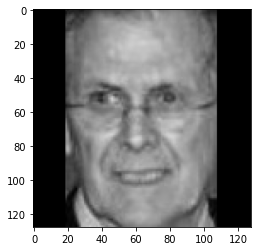

In [ ]:
sample_lfw = next(lfw_iter)
_ = plt.imshow(tf.image.grayscale_to_rgb(sample_lfw))

# Mugshot Dataset

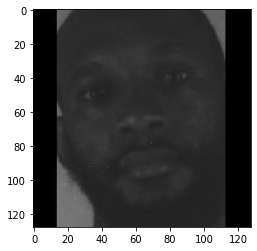

In [ ]:
mugshot_filenames = tf.data.Dataset.list_files("drive/MyDrive/mugshots_front/*.jpeg")
mugshots = mugshot_filenames.map(lambda filename: tf.io.decode_jpeg(tf.io.read_file(filename)),num_parallel_calls=tf.data.experimental.AUTOTUNE)
mugshots = mugshots.map(lambda img: tf.image.convert_image_dtype(img, tf.float32),num_parallel_calls=tf.data.experimental.AUTOTUNE)
mugshots = mugshots.cache()
mugshots = mugshots.prefetch(tf.data.experimental.AUTOTUNE)
sample_mugshot = next(iter(mugshots))
_ = plt.imshow(tf.image.grayscale_to_rgb(sample_mugshot))

# Baseline: Pix2pix

In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,data_format="channels_last", use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128,128,1])

  down_stack = [
    downsample(64, 7, apply_batchnorm=False),
    downsample(128, 1),
    downsample(256, 3),
    downsample(512, 1),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4), 
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
    print(x.shape)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(x.shape, skip.shape)
    x = tf.keras.layers.Concatenate()([x, skip])
    
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
input_img = next(iter(lfw))[tf.newaxis,...]
gen_output = generator(input_img, training=False)
_ = plt.imshow(tf.image.grayscale_to_rgb(gen_output[0, ...]))

(None, 64, 64, 64)
(None, 32, 32, 128)
(None, 16, 16, 256)
(None, 8, 8, 512)
(None, 4, 4, 512)
(None, 2, 2, 512)
(None, 1, 1, 512)
(None, 2, 2, 512) (None, 2, 2, 512)
(None, 4, 4, 512) (None, 4, 4, 512)
(None, 8, 8, 512) (None, 8, 8, 512)
(None, 16, 16, 512) (None, 16, 16, 256)
(None, 32, 32, 256) (None, 32, 32, 128)
(None, 64, 64, 128) (None, 64, 64, 64)


NameError: ignored

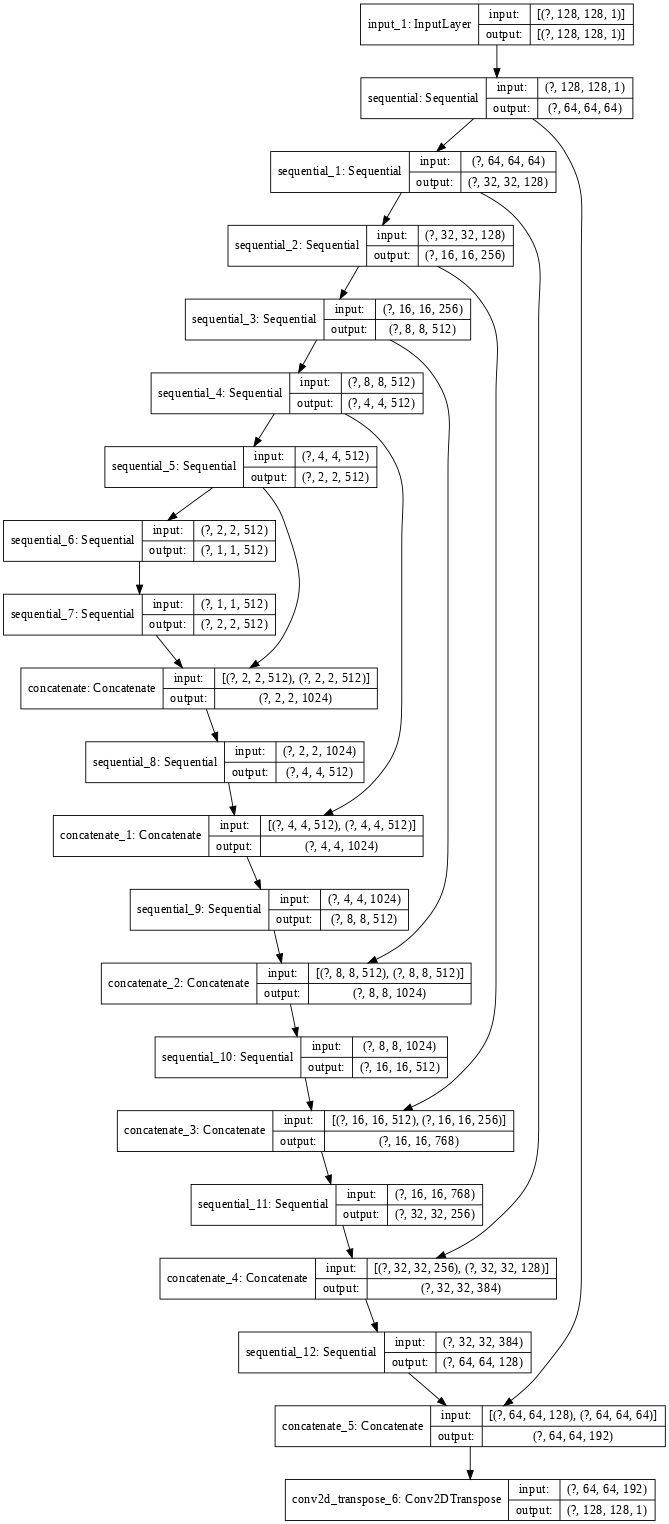

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inputs = tf.keras.layers.Input(shape=[128, 128, 1])  
  down_stack = [
    downsample(64, 1,  apply_batchnorm=False),
    downsample(64, 4),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4)
  ]
  
  flatten = tf.keras.layers.Flatten()

  dense_stack = [
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='relu')
  ]
  

  x = inputs
  for down in down_stack:
    x = down(x) 
  
  x = flatten(x)
  
  for dense in dense_stack:
    x = dense(x)
  
  return tf.keras.Model(inputs=inputs, outputs=x)

discriminator = Discriminator()
input_image = sample_mugshot[tf.newaxis, ...]
print(input_image.shape)
discriminator(input_image, training=False)

(1, 128, 128, 1)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00081422]], dtype=float32)>

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

NameError: ignored

In [ ]:
LAMBDA = 100
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#def generator_loss(discriminator_output,generat):
#  return 
  #return loss_obj(tf.ones_like(generated), generated)

def generator_loss(fake_score):
    return cross_entropy(tf.ones_like(fake_score), fake_score)

def discriminator_loss(real, fake):
  real_loss = cross_entropy(tf.ones_like(real), real)

  fake_loss = cross_entropy(tf.zeros_like(fake), fake)

  total_disc_loss = real_loss + fake_loss

  return total_disc_loss * 0.5

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer =  tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def generate_images(generator, discriminator, test_input):
  prediction = generator(test_input[tf.newaxis,...])

  plt.figure(figsize=(12, 12))

  test_input_display = tf.image.grayscale_to_rgb(test_input)
  prediction_display = tf.image.grayscale_to_rgb(prediction[0])
  display_list = [test_input_display, prediction_display]

  score = float(discriminator(prediction, training=False))

  title = ['Input Image', "{:.5f}".format(score)]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
import datetime
log_dir="drive/MyDrive/dl_face_checkpoints"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
def train_step(real_wild, real_mug, epoch):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_mug = generator(real_wild, training=True)
    
    score_real = discriminator(real_mug, training=True)
    score_fake = discriminator(fake_mug, training=True)
    
    # calculate the loss
    gen_loss = generator_loss(score_fake)
    disc_loss = discriminator_loss(score_real, score_fake)    

  # Calculate the gradients for generator and discriminator
  generator_gradients = tape.gradient(gen_loss, 
                                        generator.trainable_variables)  

  discriminator_gradients = tape.gradient(disc_loss, 
                                            discriminator.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_optimizer.apply_gradients(zip(generator_gradients, 
                                            generator.trainable_variables))
  
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))
  
  with summary_writer.as_default():
    tf.summary.scalar('gen_loss', gen_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [ ]:
def benchmark_time_for_batch(batch_size):
  start = time.time()

  for image_wild, image_mugshot in tf.data.Dataset.zip((lfw, mugshots)).batch(batch_size).take(1):
      with tf.device('device:GPU:0'):
          train_step(image_wild, image_mugshot, 0)

  time_total = time.time()-start
  time_per_sample = time_total/batch_size
  print(f"Time taken for {batch_size} samples is {time_total} sec. ")
  return time_per_sample

# tensor of size 512 has caused exception; therefore it is too much
batch_sizes = [4, 8, 16, 32, 64, 128, 256]
time_results = {}
for batch_size in batch_sizes:
  time_results[batch_size] = benchmark_time_for_batch(batch_size)
time_results

Time taken for 4 samples is 3.95804500579834 sec. 
Time taken for 8 samples is 6.983429431915283 sec. 
Time taken for 16 samples is 12.378767251968384 sec. 
Time taken for 32 samples is 25.17021083831787 sec. 
Time taken for 64 samples is 44.419532775878906 sec. 
Time taken for 128 samples is 83.31922316551208 sec. 
Time taken for 256 samples is 151.5629699230194 sec. 


{4: 0.989511251449585,
 8: 0.8729286789894104,
 16: 0.773672953248024,
 32: 0.7865690886974335,
 64: 0.6940551996231079,
 128: 0.6509314309805632,
 256: 0.5920428512617946}

In [ ]:
BATCH_SIZE = 256

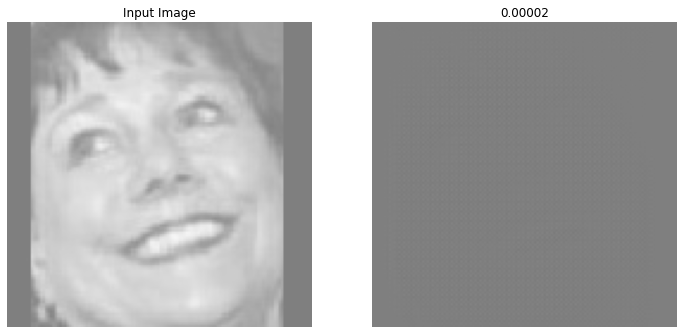

In [ ]:
generate_images(generator, discriminator, sample_lfw)

Time taken for epoch 46 is 26.52293372154236 sec


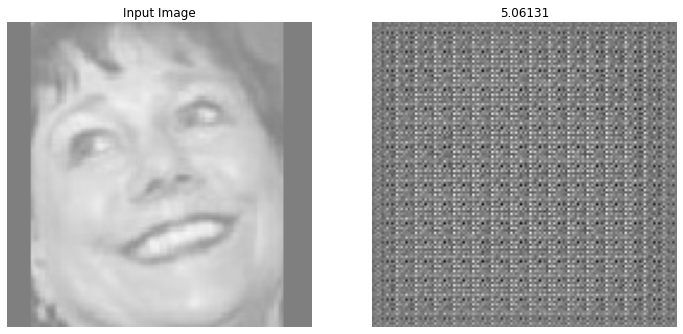

....

In [ ]:
PREV_EPOCHS =0
EPOCHS = 1000
for epoch in range(PREV_EPOCHS, EPOCHS):
  start = time.time()

  n = 0
  for image_wild, image_mugshot in tf.data.Dataset.zip((lfw, mugshots)).batch(256):
    with tf.device('device:GPU:0'):
      train_step(image_wild, image_mugshot, n)
    if n % 1 == 0:
      print ('.', end='')
    n+=1
  
  clear_output(wait=True)
  print(f"Time taken for epoch {epoch} is {time.time()-start} sec")
  generate_images(generator, discriminator, sample_lfw)  

  if n%50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f"Saving checkpoint for epoch {epoch} at {ckpt_save_path}")

In [ ]:
PREV_EPOCHS =1000
EPOCHS = 10000
for epoch in range(PREV_EPOCHS, EPOCHS):
  start = time.time()

  n = 0
  for image_wild, image_mugshot in tf.data.Dataset.zip((lfw, mugshots)).batch(256):
    with tf.device('device:GPU:0'):
      train_step(image_wild, image_mugshot, n)
    if n % 1 == 0:
      print ('.', end='')
    n+=1
  
  display.clear_output(wait=True)
  print(f"Time taken for epoch {epoch} is {time.time()-start} sec")
  generate_images(generator, discriminator, sample_lfw)  

  if n%1000 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f"Saving checkpoint for epoch {epoch} at {ckpt_save_path}")

NameError: ignored

# Cheap Autoencoder

In [ ]:
def encoder_part(input, num_channels):
    x = Conv2D(8, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_convolution')(
        input)
    x = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv_enc_1')(x)
    x=tf.keras.layers.LeakyReLU()(x)

    x = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv_enc_2')(x)
    x=tf.keras.layers.LeakyReLU()(x)   

    print('shape',x.shape)
    x = Flatten()(x)
    x = Dense(512, use_bias=False)(x)
    x = Dense(256, use_bias=False)(x)

    return x

def decoder_part(encoded, num_channels):
    dec = Dense(512, use_bias=False, input_shape = encoded.shape)(encoded)

    dec = Dense(1024, use_bias=False, input_shape = dec.shape)(dec)
    dec = tf.reshape(dec, [-1, 8, 8, num_channels])

    dec = Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', name='conv_enc_1')(dec)
    
    dec = Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', name='conv_enc_2')(dec)

    dec = Conv2DTranspose(8, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', name='conv_enc_3')(dec)
    
    decoded = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', name='conv_out')(dec)
    return decoded

def create_encoder(num_channels):
    input = Input(shape=(128, 128, 1))
    encoded = encoder_part(input, num_channels)
    print('Embedding size:',encoded.shape )
    return tf.keras.Model(inputs=input, outputs=encoded, name='encoder'), encoded.shape

def create_decoder(embedding_shape, num_channels):
    encoded = Input(shape=embedding_shape)
    
    decoded = decoder_part(encoded, num_channels)
    return tf.keras.Model(inputs=encoded, outputs=decoded, name='decoder')

In [ ]:
encoder_model, embedding_shape = create_encoder(16)
decoder_model_lfw = create_decoder([embedding_shape[1]], 16)


encoder_decoder_lfw = tf.keras.Model(encoder_model.input, decoder_model_lfw(encoder_model.output), name='straight_decoder')

encoder_decoder_lfw.summary()

shape (None, 16, 16, 64)
Embedding size: (None, 256)
Model: "straight_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
front_convolution (Conv2D)   (None, 64, 64, 8)         400       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 32, 32, 32)        6432      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 16, 16, 64)        51264     
_______________________________________________________________

In [ ]:
def image_diff_loss(generated, expected):
  return tf.reduce_sum(tf.abs(expected - generated))

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
decoder_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
@tf.function
def train_step(model, input_image, expected_image, epoch):
  with tf.GradientTape() as dec_tape:
    decoded = model(input_image, training=True)    

    decoding_loss = image_diff_loss(decoded, expected_image)

  decoder_gradients = dec_tape.gradient(decoding_loss,
                                        model.trainable_variables)
  
  decoder_optimizer.apply_gradients(zip(decoder_gradients,
                                          model.trainable_variables))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


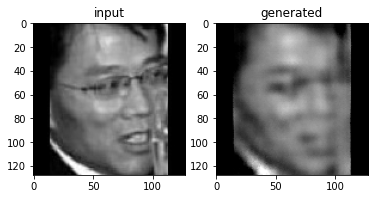

Time taken for epoch 1001 is 1.5085117816925049 sec



In [ ]:
epochs_passed = 0
next_stop_epoch = 1000

while epochs_passed <= next_stop_epoch:
    start = time.time()
    print("Epoch: ", epochs_passed)
    
    # Train
    prev_read = time.time()
    for input in lfw.batch(256):
      print ('Time taken to read data: {}'.format(time.time()-prev_read))
      print('.', end='')      
      with tf.device('device:GPU:0'):
        train_start = time.time()
        train_step(encoder_decoder_lfw, input, input, epochs_passed)
        print ('Time taken to train: {}'.format(time.time()-train_start))
      prev_read = time.time()
    print()

    clear_output(wait=True)
    
    gen_output = encoder_decoder_lfw(sample_lfw[tf.newaxis, ...], training=False)
    gen_output = gen_output[0]
    display_images((sample_lfw, gen_output), ('input', 'generated'))
    print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
    epochs_passed+=1

In [ ]:
decoder_mugshot_model = create_decoder([embedding_shape[1]], 16)

encoder_decoder_mugshot = tf.keras.Model(encoder_model.input, decoder_mugshot_model(encoder_model.output), name='mugshot_decoder')
encoder_decoder_mugshot.summary()

Model: "mugshot_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
front_convolution (Conv2D)   (None, 64, 64, 8)         400       
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 32, 32, 32)        6432      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv_enc_2 (Conv2D)          (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)    

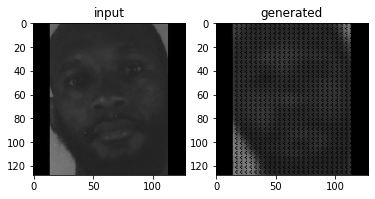

Time taken for epoch 501 is 1.0561556816101074 sec



In [ ]:
epochs_passed = 0
next_stop_epoch = 500

while epochs_passed <= next_stop_epoch:
    start = time.time()
    print("Epoch: ", epochs_passed)
    
    # Train
    prev_read = time.time()
    for input in mugshots.batch(256):
      print ('Time taken to read data: {}'.format(time.time()-prev_read))
      print('.', end='')      
      with tf.device('device:GPU:0'):
        train_start = time.time()
        train_step(encoder_decoder_mugshot, input, input, epochs_passed)
        print ('Time taken to train: {}'.format(time.time()-train_start))
      prev_read = time.time()
    print()

    clear_output(wait=True)
    
    gen_output = encoder_decoder_mugshot(sample_mugshot[tf.newaxis, ...], training=False)
    gen_output = gen_output[0]
    display_images((sample_mugshot, gen_output), ('input', 'generated'))
    print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
    epochs_passed+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


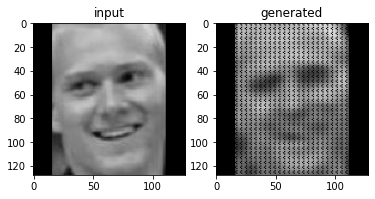

In [ ]:
sample_lfw = next(lfw_iter)
_ = plt.imshow(tf.image.grayscale_to_rgb(sample_lfw))
gen_output = encoder_decoder_mugshot(sample_lfw[tf.newaxis, ...], training=False)
gen_output = gen_output[0]
display_images((sample_lfw, gen_output), ('input', 'generated'))